#1.Importamos las librerias


In [1]:
import os
import cv2
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import matplotlib.pyplot as plt

In [2]:
#monta el drive para poder acceder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#carga la direccion del dataset
data_dir = "../content/drive/MyDrive/Colab Notebooks/Bourbaki/Grocery_store/GroceryStoreDataset/dataset"

img_size = (150,150)
batch_size = 32
seed = 42

In [4]:
df_classes = pd.read_csv(data_dir + "/classes.csv")
df_classes.sample(5)

,Class Name (str),Class ID (int),Coarse Class Name (str),Coarse Class ID (int),Iconic Image Path (str),Product Description Path (str)
67,Brown-Cap-Mushroom,67,Mushroom,36,/iconic-images-and-descriptions/Vegetables/Mus...,/iconic-images-and-descriptions/Vegetables/Mus...
32,God-Morgon-Orange-Red-Grapefruit-Juice,32,Juice,19,/iconic-images-and-descriptions/Packages/Juice...,/iconic-images-and-descriptions/Packages/Juice...
9,Lime,9,Lime,5,/iconic-images-and-descriptions/Fruit/Lime/Lim...,/iconic-images-and-descriptions/Fruit/Lime/Lim...
33,God-Morgon-Red-Grapefruit-Juice,33,Juice,19,/iconic-images-and-descriptions/Packages/Juice...,/iconic-images-and-descriptions/Packages/Juice...
54,Arla-Natural-Mild-Low-Fat-Yoghurt,54,Yoghurt,27,/iconic-images-and-descriptions/Packages/Yoghu...,/iconic-images-and-descriptions/Packages/Yoghu...


In [5]:
coarse_mapping = dict(df_classes[["Coarse Class ID (int)", "Coarse Class Name (str)"]].drop_duplicates().values)

In [6]:
coarse_mapping

{0: 'Apple',
 1: 'Avocado',
 2: 'Banana',
 3: 'Kiwi',
 4: 'Lemon',
 5: 'Lime',
 6: 'Mango',
 7: 'Melon',
 8: 'Nectarine',
 9: 'Orange',
 10: 'Papaya',
 11: 'Passion-Fruit',
 12: 'Peach',
 13: 'Pear',
 14: 'Pineapple',
 15: 'Plum',
 16: 'Pomegranate',
 17: 'Red-Grapefruit',
 18: 'Satsumas',
 19: 'Juice',
 20: 'Milk',
 21: 'Oatghurt',
 22: 'Oat-Milk',
 23: 'Sour-Cream',
 24: 'Sour-Milk',
 25: 'Soyghurt',
 26: 'Soy-Milk',
 27: 'Yoghurt',
 28: 'Asparagus',
 29: 'Aubergine',
 30: 'Cabbage',
 31: 'Carrots',
 32: 'Cucumber',
 33: 'Garlic',
 34: 'Ginger',
 35: 'Leek',
 36: 'Mushroom',
 37: 'Onion',
 38: 'Pepper',
 39: 'Potato',
 40: 'Red-Beet',
 41: 'Tomato',
 42: 'Zucchini'}

In [7]:
filter_img = [0,1,2]

In [8]:
coarse_mapping = {k: v for k, v in coarse_mapping.items() if k in filter_img}
coarse_mapping

{0: 'Apple', 1: 'Avocado', 2: 'Banana'}

In [9]:
df_train = pd.read_csv(data_dir + "/train.txt",names= ['path','fine','coarse'])
df_val = pd.read_csv(data_dir + "/val.txt",names= ['path','fine','coarse'])
df_test = pd.read_csv(data_dir + "/test.txt",names= ['path','fine','coarse'])

In [10]:
#filtra las imagenes para solo obtener las que estan ele array
df_train = df_train[df_train.coarse.isin(filter_img)]
df_val = df_val[df_val.coarse.isin(filter_img)]
df_test = df_test[df_test.coarse.isin(filter_img)]

In [11]:
#lee una imagen de la ruta data_dir mas la ruta de la imagen y la conviert en un array
image  = cv2.imread(data_dir + '/train/Fruit/Apple/Golden-Delicious/Golden-Delicious_001.jpg')
image.shape

(348, 348, 3)

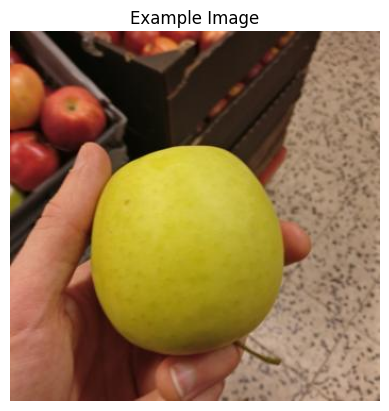

In [12]:
#permite ver la imagen como una foto
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Example Image")
plt.axis("off")
plt.show()

In [13]:
#crea una nueva columna con los nombres de la fruta de acuerdo a su id y las cuenta
df_train["coarse_name"] = df_train["coarse"].map(coarse_mapping)
counts = df_train["coarse_name"].value_counts()

In [14]:
df_train

,path,fine,coarse,coarse_name
0,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
1,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
2,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
3,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
4,train/Fruit/Apple/Golden-Delicious/Golden-Deli...,0,0,Apple
...,...,...,...,...
359,train/Fruit/Banana/Banana_041.jpg,6,2,Banana
360,train/Fruit/Banana/Banana_042.jpg,6,2,Banana
361,train/Fruit/Banana/Banana_043.jpg,6,2,Banana
362,train/Fruit/Banana/Banana_044.jpg,6,2,Banana


In [15]:
counts.index, counts.values

(Index(['Apple', 'Banana', 'Avocado'], dtype='object', name='coarse_name'),
 array([278,  45,  41]))

#2.Load Dataset with Train/Val/Test

In [16]:
#funcion que carga las imagenes y las redimensiona
def load_images_from_folder(paths):
    image_ds = []
    for path in paths:
        s = data_dir + '/' + path
        img = cv2.imread(s)
        resized = cv2.resize(img,img_size)
        image_ds.append(resized)

    image_array = np.array(image_ds)
    X = image_array/255 #normaliza la imagen
    return X

In [17]:
#creo los dataset , Train, Validation , Test
X_train = load_images_from_folder(df_train['path'].values)
X_val = load_images_from_folder(df_val['path'].values)
X_test = load_images_from_folder(df_test['path'].values)

In [18]:
X_train.shape, X_val.shape, X_test.shape

((364, 150, 150, 3), (33, 150, 150, 3), (360, 150, 150, 3))

In [19]:
y_train = np.array(df_train['coarse'])
y_val = np.array(df_val['coarse'])
y_test = np.array(df_test['coarse'])

In [20]:
y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [21]:
train_counts = dict(zip(counts.index, counts.values))
train_counts

{'Apple': np.int64(278), 'Banana': np.int64(45), 'Avocado': np.int64(41)}

In [22]:
#Balanceo del Dataset

class_counts = Counter(y_train)
print("Distribución de clases original:")
print(class_counts)
max_count = max(class_counts.values())

Distribución de clases original:
Counter({np.int64(0): 278, np.int64(2): 45, np.int64(1): 41})


In [23]:
#generador de las imagenes , crea nuevas versiones modificadas de las imagenes
datagen = ImageDataGenerator(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

In [24]:
np.unique(y_train)

array([0, 1, 2])

In [25]:
#oversampling Dinamico

X_aug = []
y_aug = []

In [26]:
#esta funcion genera imagenes de las ya creadas y con el datagenerator crea nuevas imagenes
#estas nuevas imegenes las guarda en X_aug y y_aug
for cls in np.unique(y_train):
    idx = np.where(y_train == cls)[0] #toma el arreglo de indices
    X_cls = X_train[idx]
    n_current = len(X_cls)
    n_to_generate = 1500 #max_count - n_current

    if n_to_generate > 0:
        print(f"Clase {cls}: generando {n_to_generate} imágenes aumentadas")
        gen = datagen.flow(X_cls, batch_size=1)

        for i in range(n_to_generate):
            new_img = next(gen)[0]
            X_aug.append(new_img)
            y_aug.append(cls)

Clase 0: generando 1500 imágenes aumentadas
Clase 1: generando 1500 imágenes aumentadas
Clase 2: generando 1500 imágenes aumentadas


In [28]:
X_cls.shape, len(X_aug), len(y_aug)

((45, 150, 150, 3), 4500, 4500)

In [29]:
# Combinar dataset original + aumentado ---
if X_aug:
    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    X_train_balanced = np.concatenate([X_train, X_aug], axis=0)
    y_train_balanced = np.concatenate([y_train, y_aug], axis=0)
else:
    X_train_balanced, y_train_balanced = X_train, y_train

print("\nDistribución balanceada final:")
print(Counter(y_train_balanced))


Distribución balanceada final:
Counter({np.int64(0): 1778, np.int64(2): 1545, np.int64(1): 1541})


In [54]:
X_train_balanced.shape, y_train_balanced.shape

((4864, 150, 150, 3), (4864,))

In [30]:
# Generate a random permutation of indices
permutation = np.random.permutation(len(X_train_balanced))

# Apply the permutation to both X and y
X_train_balanced = X_train_balanced[permutation]
y_train_balanced = y_train_balanced[permutation]

#3.Data Aumentation

In [31]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    #layers.RandomContrast(0.15),
    #layers.RandomBrightness(0.15),
])

In [32]:
num_classes = len(coarse_mapping)
num_classes

3

#4.Defino la Red Convolucional

In [33]:
model_frutas = models.Sequential([
    layers.Input(shape=img_size + (3,)),

    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

#5.Compilo el modelo

In [34]:
model_frutas.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

In [35]:
num_epochs = 100

history = model_frutas.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)
    ]
)

Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.3793 - loss: 1.0898 - val_accuracy: 0.6667 - val_loss: 1.0464 - learning_rate: 1.0000e-05
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4205 - loss: 1.0472 - val_accuracy: 0.6364 - val_loss: 0.9302 - learning_rate: 1.0000e-05
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4327 - loss: 1.0370 - val_accuracy: 0.7879 - val_loss: 0.7085 - learning_rate: 1.0000e-05
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4306 - loss: 1.0297 - val_accuracy: 0.7576 - val_loss: 0.4685 - learning_rate: 1.0000e-05
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.4417 - loss: 1.0318 - val_accuracy: 0.8788 - val_loss: 0.3226 - learning_rate: 1.0000e-05
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.4095 - loss: 1.0290 - val_accuracy: 0.8182 - val_loss: 0.3439 - learning_rate: 1.0000e-05
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/st

In [36]:
model_frutas.save("./models/cnn_grocery_store.h5")

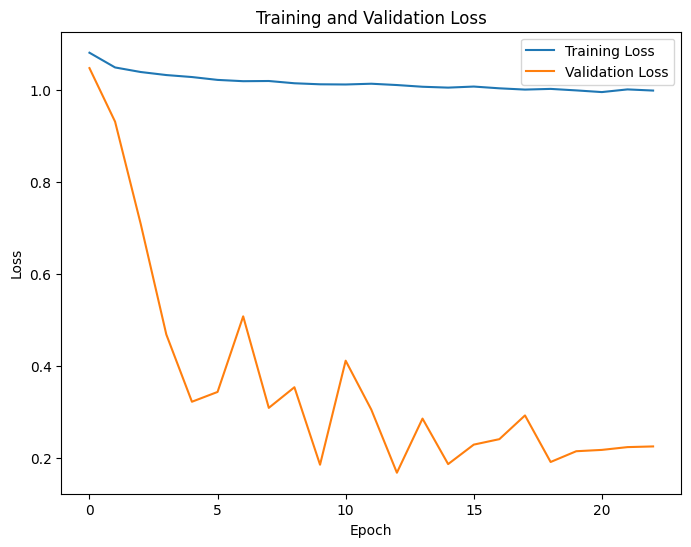

In [37]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#6.F-1 SCORE

In [38]:
y_probs = model_frutas.predict(X_test)
y_preds = np.argmax(y_probs, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step


In [39]:
f1 = f1_score(y_test, y_preds, average='weighted')
print(f"\nWeighted F1 Score: {f1:.4f}")


Weighted F1 Score: 0.8897


In [40]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       276
           1       0.85      0.85      0.85        40
           2       0.69      0.61      0.65        44

    accuracy                           0.89       360
   macro avg       0.82      0.80      0.81       360
weighted avg       0.89      0.89      0.89       360



#7.Confusion Matrix

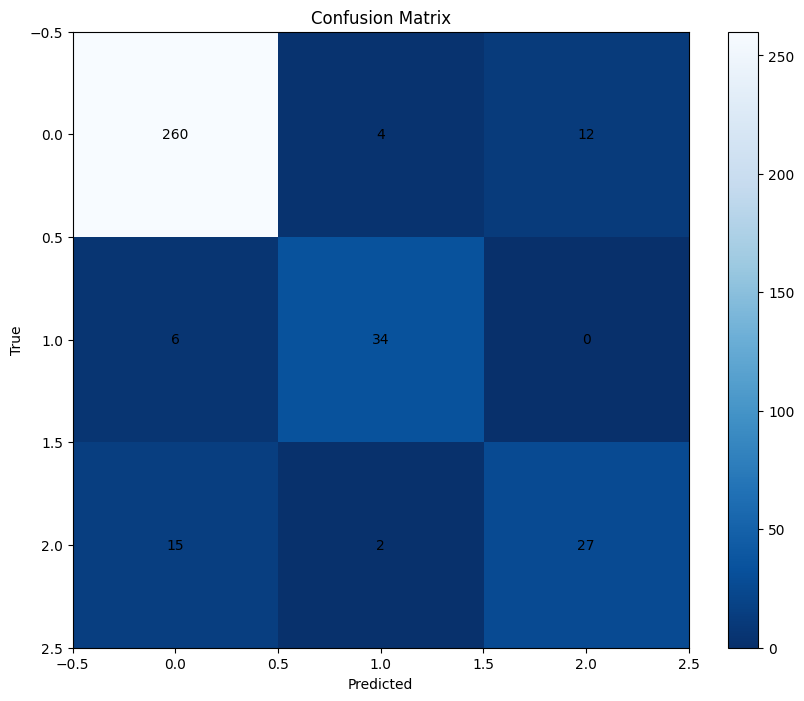

In [41]:
cm = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap='Blues_r')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
# Agregar valores en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center', color='black')

plt.colorbar()
plt.show()

#8.Modelo RESNET50


In [63]:
# 8.1. Construir la red preentrenada para tranferencia de aprendizaje
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50


# 1 Creo el modelo resnet con sus pesos preentrenados
Resnet_frutas = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,))

# 2. Congelar el modelo base
Resnet_frutas.trainable = False

# 3. Construir el modelo usando la API funcional de Keras
# Define la capa de entrada
inputs = layers.Input(shape=img_size + (3,))

# 4.data Aumentation (usamos 'x' para el flujo)
x = layers.RandomFlip("horizontal_and_vertical")(inputs)
x = layers.RandomRotation(0.2)(x)
x = layers.RandomZoom(0.2)(x)
x = layers.RandomContrast(0.1)(x)

# 5.Aplica el preprocesamiento específico de ResNet a los inputs aumentados
x = tf.keras.applications.resnet.preprocess_input(x)

# 6.Pasa las entradas preprocesadas a la base ResNet50
x = Resnet_frutas(x)

# 7.Añadimos capas personalizadas encima
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# 8.otra capa densa de neuronas
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# 9.capa de salida con la funcion softmax
outputs = layers.Dense(num_classes, activation='softmax')(x)

# 10.Crea el modelo final
model_frutas2= models.Model(inputs=inputs, outputs=outputs)




In [64]:
#8.3 Compilo el modelo que uso RESNET50
model_frutas2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy'
    ]
)

In [65]:
model_frutas2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_2       │ (None, 150, 150,  │          0 │ input_layer_6[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_2   │ (None, 150, 150,  │          0 │ random_flip_2[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_2       │ (None, 150, 150,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_1   │ (None, 150, 150,  │          0 │ random_zoom_2[0]… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_6          │ (None, 150, 150)  │          0 │ random_contrast_… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_7          │ (None, 150, 150)  │          0 │ random_contrast_… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 150, 150)  │          0 │ random_contrast_… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_2 (Stack)     │ (None, 150, 150,  │          0 │ get_item_6[0][0], │
│                     │ 3)                │            │ get_item_7[0][0], │
│                     │                   │            │ get_item_8[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 150, 150,  │          0 │ stack_2[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 5, 5,      │ 23,587,712 │ add_2[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     32,896 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 3)         │        387 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,145,539 (92.11 MB)

 Trainable params: 557,827 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [66]:
#8.4 Corremos el modelo con el RESNET50

num_epochs = 100

history_resnet = model_frutas2.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=num_epochs,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)
    ]
)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 27s 339ms/step - accuracy: 0.3183 - loss: 1.6114 - val_accuracy: 0.1515 - val_loss: 1.6559 - learning_rate: 1.0000e-05
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.3227 - loss: 1.3634 - val_accuracy: 0.1515 - val_loss: 1.3390 - learning_rate: 1.0000e-05
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 254ms/step - accuracy: 0.3380 - loss: 1.2210 - val_accuracy: 0.1515 - val_loss: 1.1515 - learning_rate: 1.0000e-05
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.3314 - loss: 1.1619 - val_accuracy: 0.6364 - val_loss: 1.0604 - learning_rate: 1.0000e-05
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.3347 - loss: 1.1445 - val_accuracy: 0.6667 - val_loss: 1.0211 - learning_rate: 1.0000e-05
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.3368 - loss: 1.1356 - val_accuracy: 0.6667 - val_loss: 0.9964 - learning_rate: 1.0000e-05
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/ste

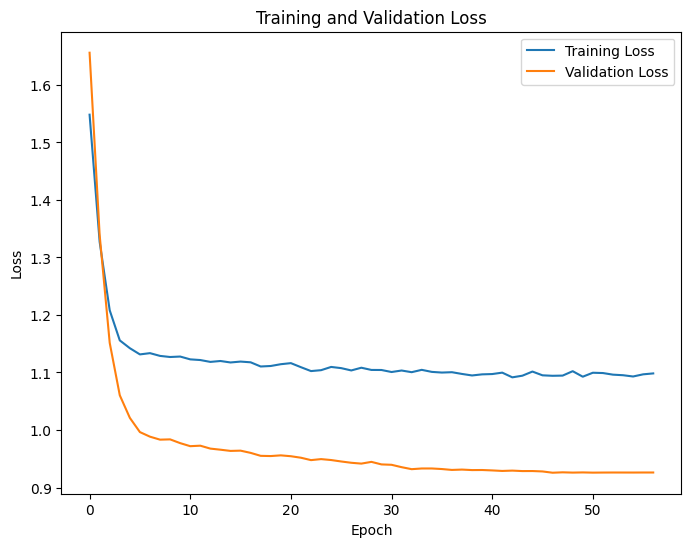

In [67]:
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs_range = range(len(history_resnet.history['loss']))

plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [68]:
#predicciones usando RESNET50
y_probs_resnet = model_frutas2.predict(X_test)
y_preds_resnet = np.argmax(y_probs_resnet, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step


In [69]:
f1_resnet= f1_score(y_test, y_preds_resnet, average='weighted')
print(f"\nWeighted F1 Score: {f1_resnet:.4f}")


Weighted F1 Score: 0.6654


In [70]:
print(classification_report(y_test, y_preds_resnet))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       276
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00        44

    accuracy                           0.77       360
   macro avg       0.26      0.33      0.29       360
weighted avg       0.59      0.77      0.67       360



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#CONCLUSIONES
Disclaimer : por motivos de procesamiento, se usaron imagenes de 150x150 aunque el modelo resnet pide imagenes de 224x224, se usaron este tamañao por que sino el modelo no corria.

1. ¿Cuál modelo obtuvo mejor f1-score y por qué?

en el f1-score del modelo entrenado localmente es mas alto , pero tambien puede deberse por el desbalanceo de las imagenes que el resnet no alcanza a captar todas las clases , pero con la clase 0 alcanza a tener un score parecido al score entrenado localmente , tambien puede deberse a que no se usan imagenes 224x224 que pide el modelo resnet , y el modelo esta bastante sesgado aun en el dataset de validacion y de test


2. ¿Qué tan diferente fue el tiempo de entrenamiento?
Con los modelos preentrenados es mas rapido el proceso de entrenamiento ya que solo es cargar los pesos del modelo


3. ¿Qué ventajas observas al usar modelos preentrenados?
la ventaja de los modelo preentrenados es la velocidad de compilacion, y que no se debe preentrenar tanto el modelo de la red

4. ¿Hay riesgo de sobre ajuste en alguno de los modelos?
el riesgo es muy alto , como en este caso que el modelo no pudo detectar las otras clases que se usaron por el desbalanceo de las clases , en este caso si creo que es mejor usar el modelo entrenado locamente por el desbalance.